## Load libraries

In [111]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

## Load data

In [3]:
PATH = os.getcwd() + "/Data"
# Ścieżki do folderów z danymi
data_paths = {
    'Crime': PATH + '/Crime',
    'Entertainment': PATH + '/Entertainment',
    'Politics': PATH + '/Politics',
    'Science': PATH + '/Science'
}

# Wczytanie danych
texts = []
labels = []
for label, path in data_paths.items():
    files = os.listdir(path)
    for file_name in files:
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path):  # Sprawdzenie, czy element jest plikiem
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read()
                texts.append(text)
                labels.append(label)

## Data analysis

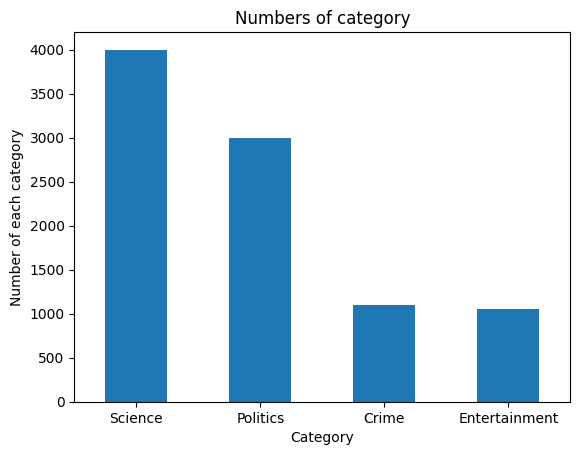

In [22]:
df = pd.DataFrame(labels, columns=['Category'])
df['Category'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title("Numbers of category")
plt.ylabel("Number of each category")
plt.show()

In [23]:
df['Category'].value_counts()

Category
Science          4000
Politics         3001
Crime            1100
Entertainment    1053
Name: count, dtype: int64

In [24]:
df['Text'] = [row for row in texts]
df.head()

,Category,Text
0,Crime,\nIn article <1993Apr21.001707.9999@ucsu.Color...
1,Crime,"\n""The security of the system should depend on..."
2,Crime,Message-ID: <1qn1ic$hp6@access.digex.net>\nNNT...
3,Crime,\n1) I think that most of us can afford a stam...
4,Crime,\nBrad Templeton (brad@clarinet.com) wrote:\n:...


In [25]:
len(df.Text.unique())

6847

## Remove redundant category

In [26]:
correct_labels = []
correct_texts = []
for label, text in zip(labels, texts):
    if label == "Science" or label== "Politics":
        correct_texts.append(text)
        correct_labels.append(label)

print(len(correct_labels))
print(len(correct_texts))

7001
7001


## Data cleaning

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

print(stop_words)

def remove_emails(text):
    """This function remove emails from text using regex."""
    pattern = r'\S+@\S+'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def clean_text(text):
    """This function clean text from unnecessary words, phrase and characters."""
    text = remove_emails(text)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization
    tokens = text.lower().split()

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    tokens = [token for token in tokens if not token.isdigit()]

    # Using lemmatization
    tokens = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in tokens]
    # Połączenie tokenów z powrotem w tekst
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [31]:
correct_texts[0]

'Sender: hallam@vxdesy.desy.de (Phill Hallam-Baker)\nReply-To: hallam@zeus02.desy.de\nOrganization: DESYDeutsches Elektronen Synchrotron, Experiment ZEUS bei HERA\nReferences: <C4xILw.Hpp@dscomsa.desy.de> <765444d1763278t86@infoserv.com> <C4zJ86.BFF@dscomsa.desy.de> <C4zHys.6D9@news.claremont.edu>\nDate: Tue, 6 Apr 1993 14:44:26 GMT\n\n\nIn article <C4zHys.6D9@news.claremont.edu>, ebrandt@jarthur.claremont.edu (Eli Brandt) writes:\n\n|>In article <C4zJ86.BFF@dscomsa.desy.de> hallam@zeus02.desy.de writes:\n|>>A State is defined by its ability to create laws, ergo when the state is not\n|>>able to make laws we are not talking about a fully functioning state.\n|>\n|>There are always some areas on which the state is able to make and\n|>enforce laws, and some on which it is not.  To add some relevance to\n|>the group in which I happen to be reading this, the U.S. government\n|>circa 1800 could not have created laws such as present Federal\n|>gun-control legislation.  Was it not a state?\n\n

In [27]:
cleaned_texts = [clean_text(text) for text in correct_texts]
cleaned_texts[0]

'sender phill hallambaker replyto organization desydeutsches elektronen synchrotron experiment zeus bei hera reference date tue apr gmt article eli brandt write article write state define ability create laws ergo state able make laws talk fully function state always areas state able make enforce laws add relevance group happen read us government circa could create laws present federal guncontrol legislation state yes always power constitution limit areas government exercise power constitution change however frequently example prohibition government power permit alcohol sell although state capacity change constitution enable constitutional provision merely matter form dictate manner power exercise piece paper prevent abuse example imprisonment socialist presidential candidate oppose world war clear breach first ammendment unite state clearly capacity bring meaningful arm control measure large group powerful warlords could prevent measure force would admit power federal government uphold

## Change label to numbers

In [32]:
label_to_index = {label: index for index, label in enumerate(set(correct_labels))}
labels = [label_to_index[label] for label in correct_labels]

## Text statistics

In [56]:
words = ' '.join(cleaned_texts)
words = re.findall(r'\w+', words.lower())
unique_words = set(words)
len(unique_words)
print("Number of unique words:", len(unique_words))

Number of unique words: 53566


In [82]:
words1 = ' '.join(cleaned_texts)
words1 = re.findall(r'\w+', words1)
print(f"Number of all words {len(words1)}")

Number of all words 1155196


In [74]:
frequency = Counter(words)
frequency.most_common(10)

[('write', 7462),
 ('would', 7240),
 ('one', 6275),
 ('use', 6134),
 ('people', 5755),
 ('article', 5678),
 ('say', 5646),
 ('get', 5230),
 ('know', 4589),
 ('make', 4557)]

In [75]:
sum_of_10000 = 0
for word, frequency in frequency.most_common(10000):
    sum_of_10000 += frequency

print(f"Number of 500 first words {sum_of_10000} - {round(sum_of_10000/len(words),2) * 100}%")

Number of 500 first words 1053668 - 91.0%


## Data preparation

In [77]:
# Text tokenization
max_words = 12000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)

# maximum sequence length
max_sequence_length = 150

# Aligning sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Division of data into training and test collection

train_data, val_test_data, train_labels, val_test_labels = train_test_split(padded_sequences, labels, test_size=0.25, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, test_size=0.4, random_state=42)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 5250
Number of validation examples: 1050
Number of test examples: 701


## Model preparation and training

In [92]:
# Tworzenie modelu
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(keras.layers.GRU(128, return_sequences=True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GRU(128, return_sequences=True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GRU(64))
model.add(keras.layers.Dense(len(label_to_index), activation='softmax'))

# Kompilacja modelu
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Trenowanie modelu
history = model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(val_data, val_labels), callbacks=[callback])

# Ocena modelu na zbiorze testowym
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

2023-06-06 22:27:45.796110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 22:27:45.797288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 22:27:45.798532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-06-06 22:27:46.123046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 22:27:46.124942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 22:27:46.126443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

165/165 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8269

2023-06-06 22:28:46.730587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 22:28:46.732468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 22:28:46.733782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

165/165 [==============================] - 64s 357ms/step - loss: 0.3835 - accuracy: 0.8269 - val_loss: 0.2891 - val_accuracy: 0.8914
Epoch 2/20
165/165 [==============================] - 55s 332ms/step - loss: 0.1577 - accuracy: 0.9463 - val_loss: 0.1869 - val_accuracy: 0.9390
Epoch 3/20
165/165 [==============================] - 54s 329ms/step - loss: 0.1248 - accuracy: 0.9640 - val_loss: 0.1449 - val_accuracy: 0.9495
Epoch 4/20
165/165 [==============================] - 58s 352ms/step - loss: 0.0494 - accuracy: 0.9832 - val_loss: 0.1869 - val_accuracy: 0.9467
Epoch 5/20
165/165 [==============================] - 63s 385ms/step - loss: 0.0274 - accuracy: 0.9905 - val_loss: 0.2341 - val_accuracy: 0.9429
Epoch 6/20
22/22 [==============================] - 2s 79ms/step - loss: 0.1809 - accuracy: 0.9529
Loss: 0.18094003200531006, Accuracy: 0.952924370765686


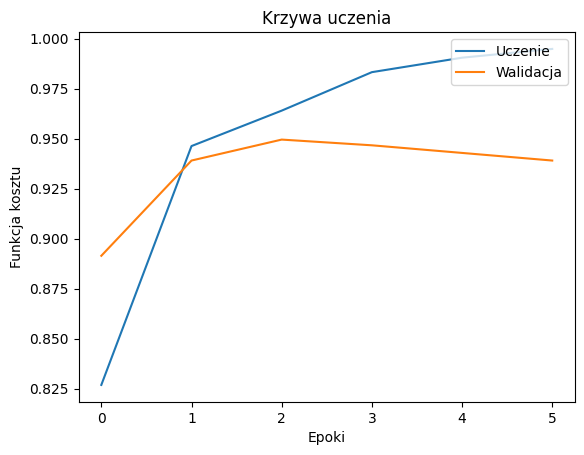

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Krzywa uczenia')
plt.xlabel('Epoki')
plt.ylabel('Funkcja kosztu')
plt.legend(['Uczenie', 'Walidacja'], loc='upper right')
plt.show()

In [94]:
model.save('model/')

2023-06-06 22:34:52.470918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 22:34:52.472540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 22:34:52.474057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [95]:
model2 = keras.models.load_model('model/')

2023-06-06 22:35:01.489412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-06 22:35:01.489545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-06 22:35:01.489643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Model testing

In [96]:
predictions = model2.predict(test_data)

2023-06-06 22:35:10.528156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 22:35:10.530180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 22:35:10.531615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 2s 64ms/step


In [97]:
prediction = np.argmax(predictions, axis=1)

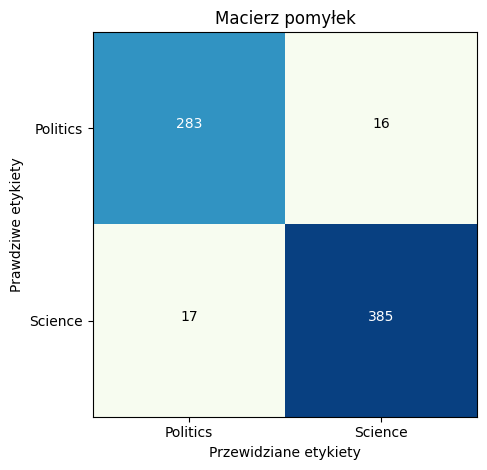

In [105]:
# Pobranie prawdziwych etykiet i przewidywanych etykiet
y_true = test_labels
y_pred = prediction

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_true, y_pred)


# Wyświetlanie macierzy pomyłek na wykresie
plt.imshow(cm, interpolation='nearest', cmap='GnBu')
plt.title('Macierz pomyłek')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Politics', 'Science'])
plt.yticks(tick_marks, ['Politics', 'Science'])
plt.xlabel('Przewidziane etykiety')
plt.ylabel('Prawdziwe etykiety')

# Dodanie wartości do komórek macierzy pomyłek
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [112]:
print(f"Precision: {precision_score(test_labels, prediction)}")
print(f"Recall: {recall_score(test_labels, prediction)}")
print(f"F1 score: {f1_score(test_labels, prediction)}")

Precision: 0.9600997506234414
Recall: 0.9577114427860697
F1 score: 0.9589041095890413
